In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("GPU Available:", tf.test.is_gpu_available())


import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
import ast
from wfdb import processing
from scipy.fftpack import fft, ifft 
import pywt as pw
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import Preprocessing
import FeatureExtraction
from importlib import reload
import transformers
import random
from transformers import Transformers
import scipy.signal as signal
from skimage.restoration import denoise_wavelet
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib
from tensorflow import keras
from keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Concatenate, GlobalAveragePooling1D, BatchNormalization, ReLU

2023-07-23 16:58:32.792596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-07-23 16:58:53.350531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-23 16:58:56.769017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-23 16:58:56.769774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

GPU Available: True


loading the signals

In [2]:
reload(Preprocessing)

load = Preprocessing.preprocess()
X = load.loadSignal()


""" a 3D array of shape (19601, 12, 1000) where the first dimension represents the number of ECG signals,
 the second dimension represents the number of leads, and the third dimension represents the length of each signal. """


 
origin_signals = np.zeros((21799, 12, 1000))
# origin_test_signals = np.zeros((2198, 12, 1000))

for sig in range(X.shape[0]):
    for lead in range(X.shape[2]):
        
        origin_signals[sig, lead, :] = X[sig].T[lead][:] 

# for sig in range(x_test.shape[0]):
#     for lead in range(x_test.shape[2]):
        
#         origin_test_signals[sig, lead, :] = x_test[sig].T[lead][:] 



""" highpassedfiltered are just baseline removed """
# loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')


""" 'bandpass_filtered.npy' contains signals that have been thourogh 
baseline removal + moving avg + bandpass filter [0.5 - 25] """ 

# loaded_bandpassedfiltered_signal = np.load('bandpass_filtered_25.npy')

" 'bandpass_filtered.npy' contains signals that have been thourogh \nbaseline removal + moving avg + bandpass filter [0.5 - 25] "

In [2]:
reload(Preprocessing)

load = Preprocessing.preprocess()
Y = load.loadStatement()

In [28]:
reload(Preprocessing)

load = Preprocessing.preprocess()
y = load.loadStatement()

In [30]:
y['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21799, dtype: object

Freq Analysis

In [3]:
loaded_waveletfiltered_signals = np.load('wavelet_filtered.npy')
# loaded_waveletfiltered_signals = loaded_waveletfiltered_signals.astype('float32')

In [4]:
loaded_waveletfiltered_signals.shape

(21799, 12, 1000)

In [4]:
filter = Preprocessing.preprocess()
sample_highpass_filtered = filter.highpassfilter(origin_signals[0][0], 100, 4, 0.5)
sample_bandpass_filtered = filter.bandpassfilter(origin_signals[0][0], 100, 4, 0.1, 35)
sample_movingavg_filtered = filter.movingaveragefilter(origin_signals[0][0])

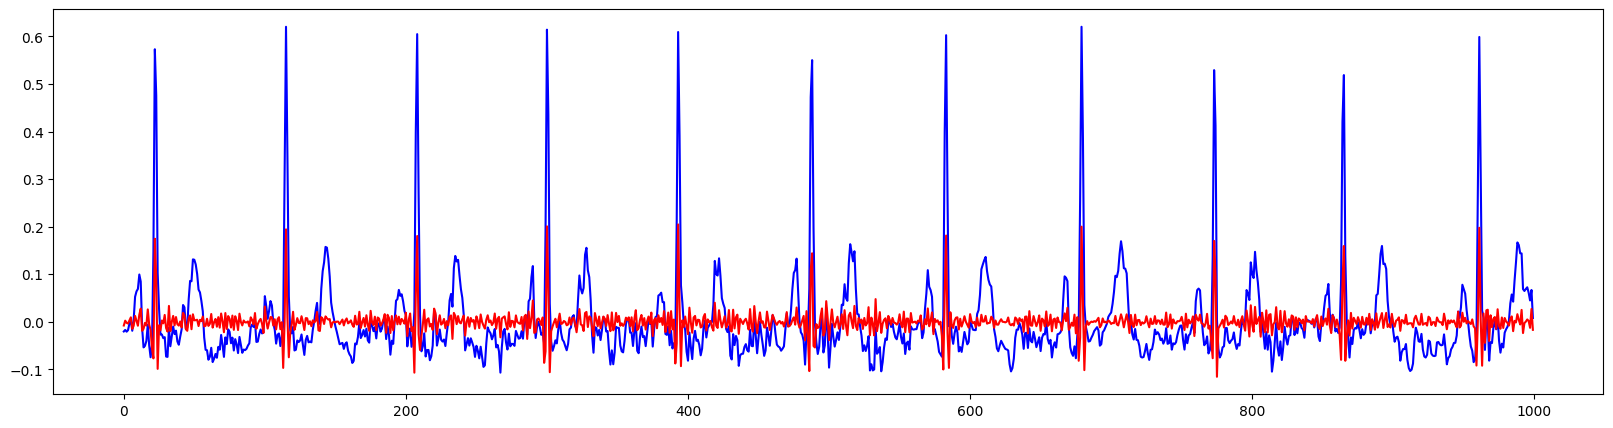

In [5]:
reload(Preprocessing)
show = Preprocessing.preprocess()

show.noise_representation(origin_signals[0][0], loaded_waveletfiltered_signals[0][0])
show.noise_representation(origin_signals[0][0], sample_highpass_filtered)
show.noise_representation(origin_signals[0][0], sample_bandpass_filtered)
show.noise_representation(origin_signals[0][0], sample_movingavg_filtered)

In [ ]:
reload(transformers)
T = Transformers()
T.FFT(origin_signals[0][0][:])

Noise-removal

In [5]:
reload(Preprocessing)

""" all the filtering techniques are applied to the train signals """
filter = Preprocessing.preprocess()

baseline_removed_signals, bandpassfiltered_signals, smoothedfiltered_signals = np.zeros((19601, 12, 1000)), np.zeros((19601, 12, 1000)), np.zeros((19601, 12, 1000))


for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):
        

        """ baseline removal """
        baseline_removed_signals[sig][lead] = filter.highpassfilter(origin_signals[sig][lead][:], 100, 4, 0.5)



In [ ]:
""" smoothing using wavelets
this changes have been applied to the baseline filtered signals """

reload(Preprocessing)
filter = Preprocessing.preprocess()
waveletfiltered_signals = np.zeros((21799, 12, 1000))
loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')

for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        waveletfiltered_signals[sig][lead] = filter.wavelet_denoising(loaded_highpassedfiltered_signal[sig][lead][:])
        

In [ ]:
for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        smoothedfiltered_signals[sig][lead] = filter.movingaveragefilter(origin_signals[sig][lead][:])

np.save('movingavg_filtered.npy', bandpassfiltered_signals)
    


In [ ]:

for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        """ smoothing the variations """
        bandpassfiltered_signals[sig][lead] = filter.bandpassfilter(baseline_removed_signals[sig][lead][:], 100, 4, 0.5, 35)

# np.save('bandpass_filtered.npy', bandpassfiltered_signals)


Extracting Features

In [5]:
"""  
locating the R Peaks for the entire dataset
- R_peaks should have a shape of (19601, 12), representing the R peak locations for each signal and lead.
- RR_intervals should have a shape of (19601, 12), representing the RR intervals for each signal and lead. 

"""


reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()

# loaded_waveletfiltered_signals = np.load('wavelet_filtered.npy')
R_peaks = []
RR_intervals = []


for signal in range(loaded_waveletfiltered_signals.shape[0]):
    # # signal_r_peaks = []
    # # for lead in signal:
    r_peaks, rr_intervals = extractor.R_peak_detection(loaded_waveletfiltered_signals[signal][1][:])
    r_peaks = np.array(r_peaks)
    # rr_intervals = np.diff(r_peaks)
    rr_intervals = np.array(rr_intervals)
    # # signal_r_peaks.append(r_peaks)
    R_peaks.append(r_peaks)
    RR_intervals.append(rr_intervals)



In [ ]:
reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()

for lead in range(11):
    extractor.R_peak_detection(loaded_waveletfiltered_signals[0][lead])

""" 
the HR and HRV are unique for an individual, 
but the measurements obtained from different leads may show slight variations 
due to the specific placement and orientation of the electrodes used to capture the signals

 """
""" 
the lead commonly used for HRV analysis is Lead II.
 """

"""        hrv_features = [
            mean_rr,
            std_rr,
            rmssd, 
            nn50, 
            pnn50, 
            total_power, 
            vlf, 
            lf, 
            hf, 
            lf_norm,
            hf_norm, 
            lf_hf_ratio, 
            lf_hf_ratio_log, 
            total_power_log, 
            lf_hf_ratio_log_norm
        ]
        
        """

reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()

HRV_features = []

for signal in range(loaded_waveletfiltered_signals.shape[0]):
    
    HRV_features.append(extractor.calculate_hrv_features(RR_intervals[signal][1]))


In [ ]:

""" 
the HR and HRV are unique for an individual, 
but the measurements obtained from different leads may show slight variations 
due to the specific placement and orientation of the electrodes used to capture the signals

 """
""" 
the lead commonly used for HRV analysis is Lead II.
 """

"""        hrv_features = [
            mean_rr,
            std_rr,
            rmssd, 
            nn50, 
            pnn50, 
            total_power, 
            vlf, 
            lf, 
            hf, 
            lf_norm,
            hf_norm, 
            lf_hf_ratio, 
            lf_hf_ratio_log, 
            total_power_log, 
            lf_hf_ratio_log_norm
        ]
        
        """

reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()

HRV_features = []

for signal in range(loaded_waveletfiltered_signals.shape[0]):
    
    HRV_features.append(extractor.calculate_hrv_features(RR_intervals[signal][1]))


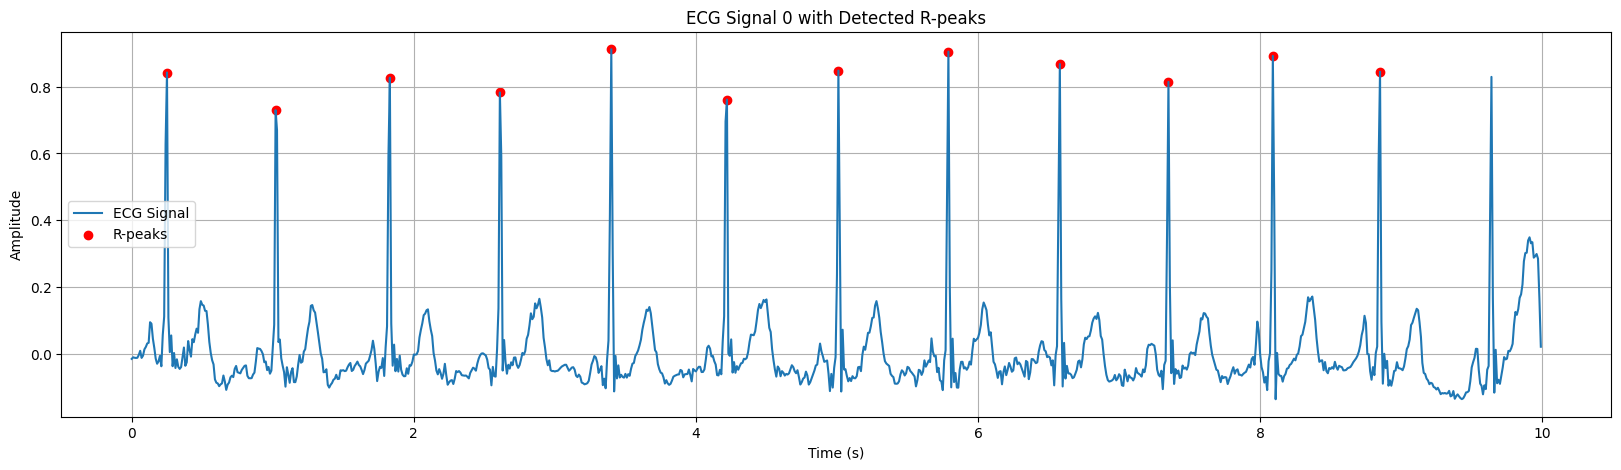

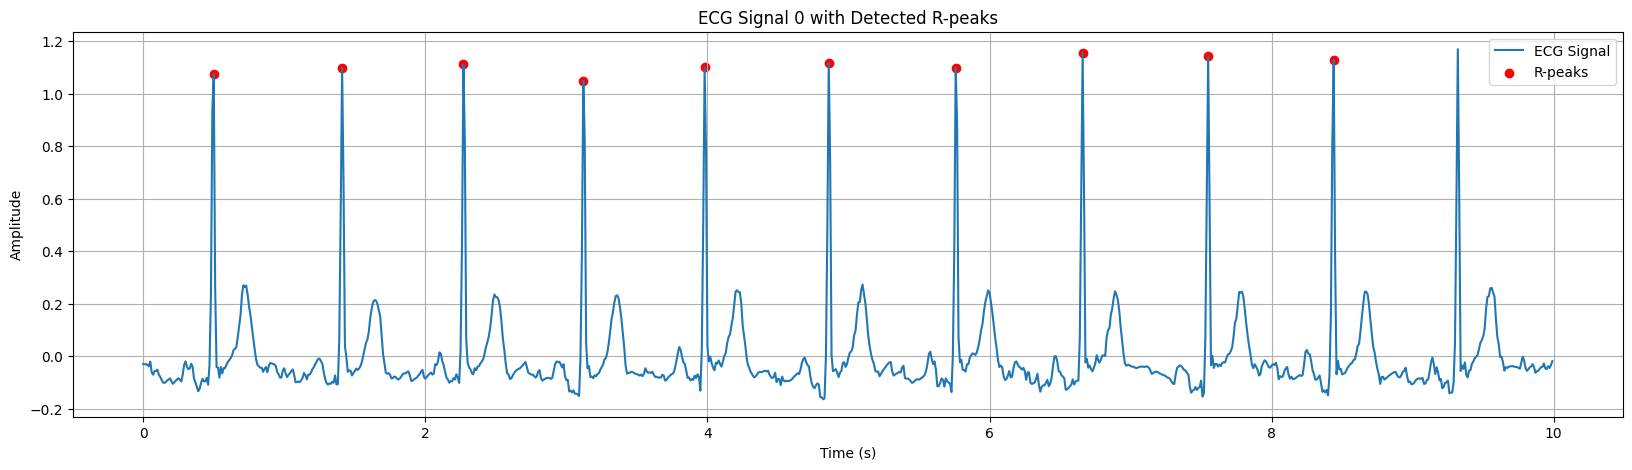

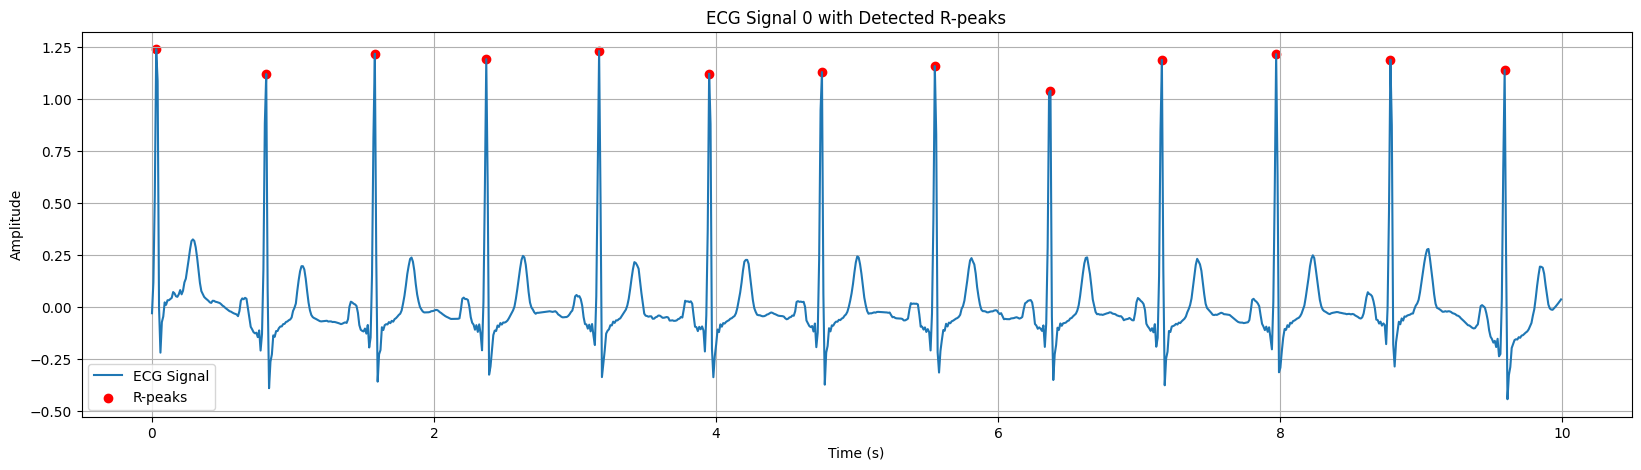

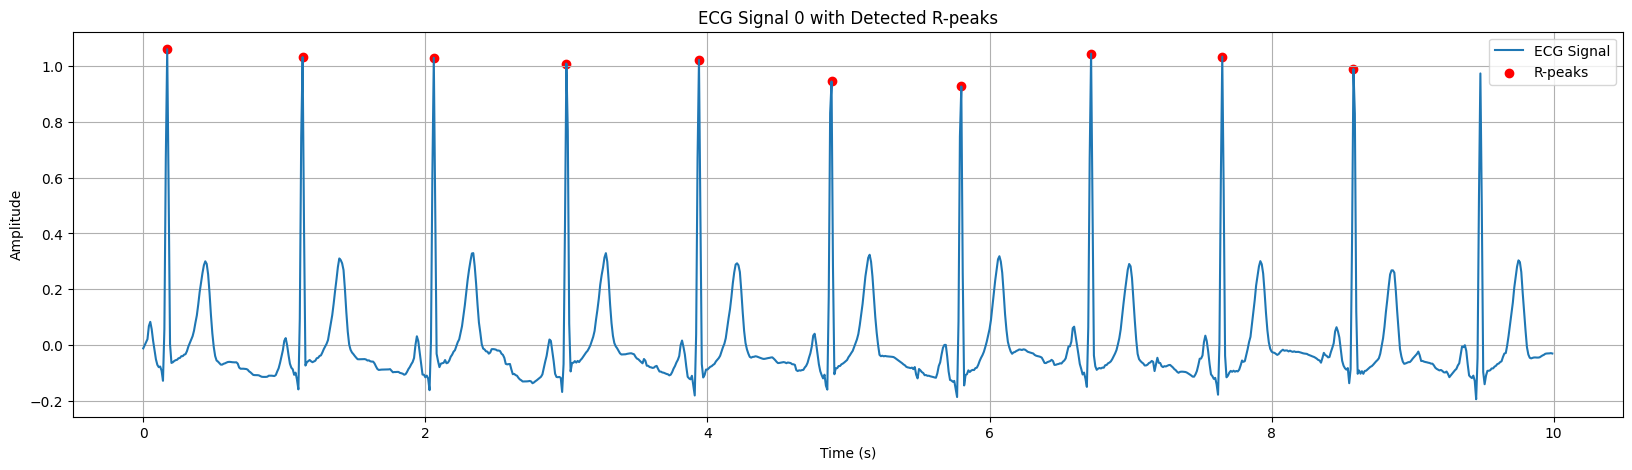

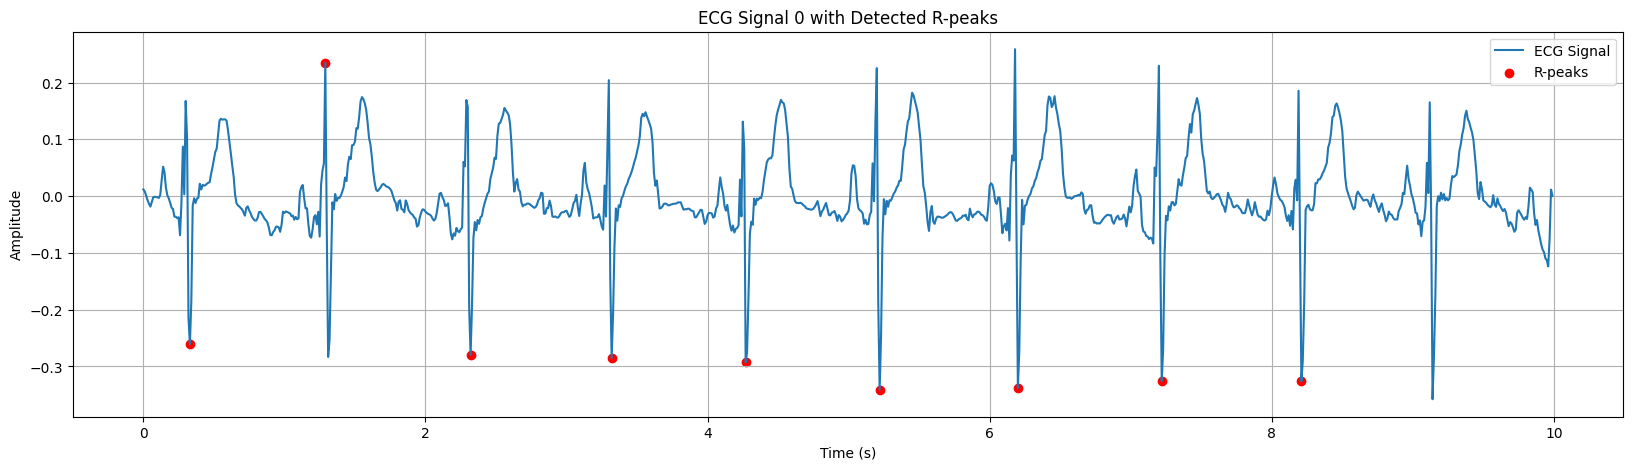

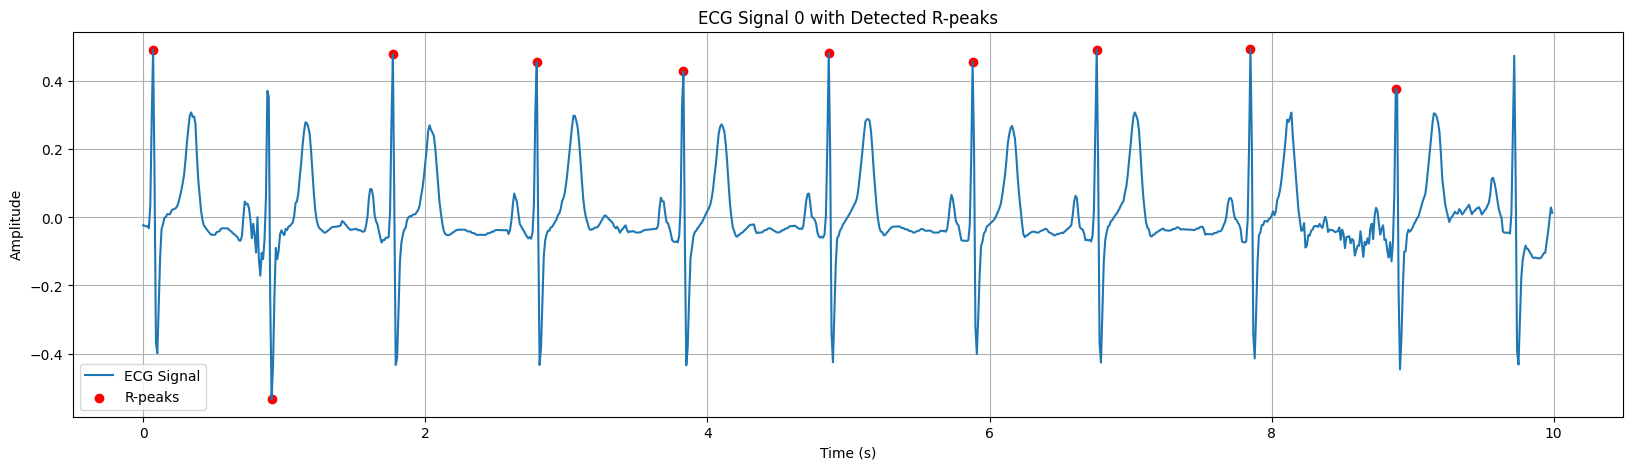

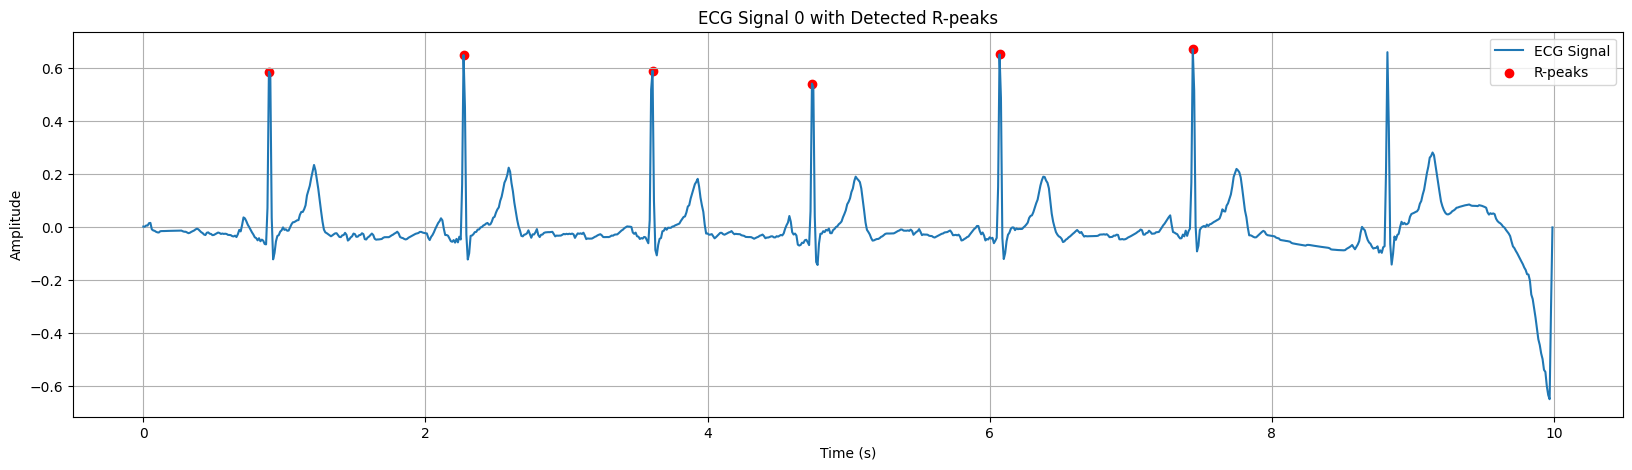

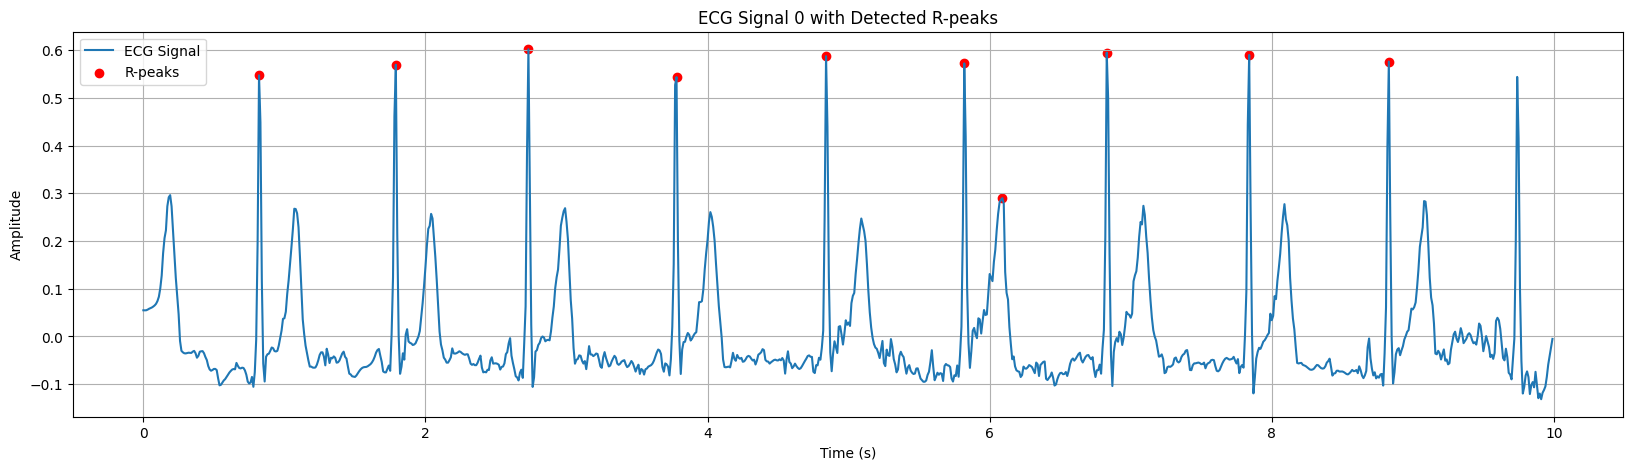

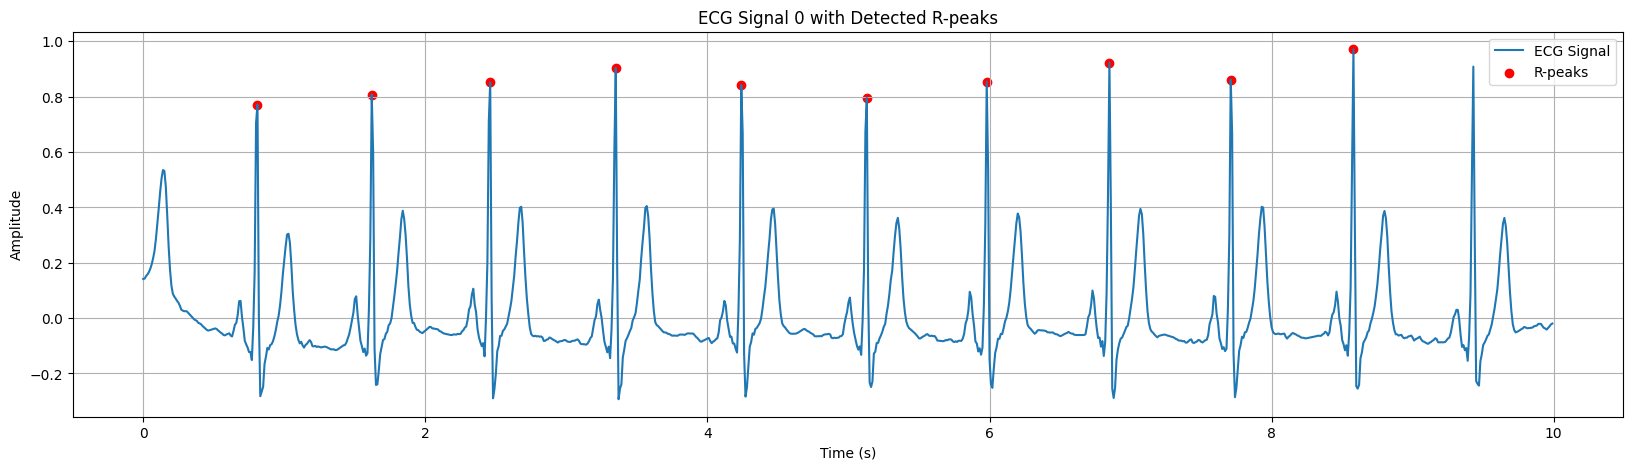

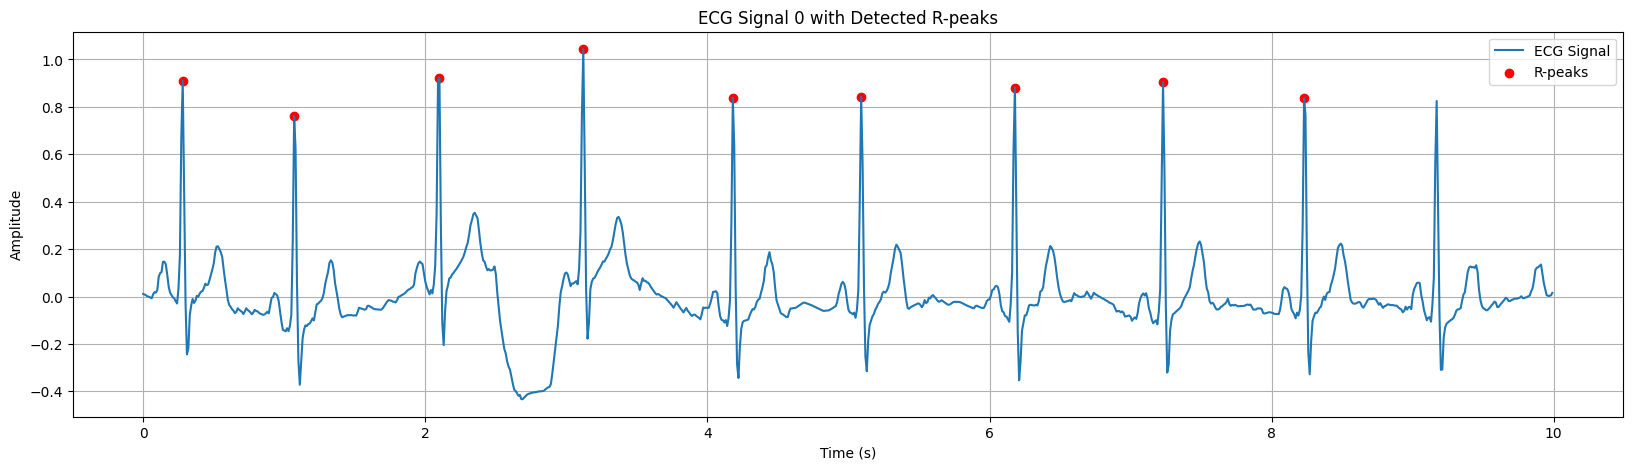

In [12]:
reload(FeatureExtraction)
extractor = FeatureExtraction.QRS()
random_index = [random.randint(0, 100) for i in range(10)]
for index in random_index:
    extractor.R_peak_detection(loaded_waveletfiltered_signals[index][1])

In [ ]:
# Identify the missing indices
missing_indices = [i for i, label in enumerate(y_train) if len(label) == 0]

# Remove the missing indices from signals and labels
filtered_signals = np.delete(origin_signals, missing_indices, axis=0)
filtered_labels = np.delete(y_train, missing_indices, axis=0)

In [31]:
y_train_flat = [label[0] for label in y_train if len(label) > 0]
len(y_train_flat)

19230

In [18]:
origin_signals = origin_signals.reshape((19601, -1))
origin_signals.shape

(19601, 12000)

In [21]:
count = 0
for index in y_train_encoded:
    if index == 0: 
        count = count +1
count

4402

In [3]:
origin_signals = origin_signals.reshape((19601, -1))
origin_signals.shape

(19601, 12000)

In [4]:
from sklearn.preprocessing import LabelEncoder

y_train_flat = [label[0] for label in y_train if len(label) > 0]
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train_flat)


In [5]:
missing_indices = [i for i, label in enumerate(y_train) if len(label) == 0]


In [6]:
filtered_signals = np.delete(origin_signals, missing_indices, axis=0)


In [6]:
""" 'age', 'sex', 'infarction_stadium1', 'infarction_stadium2', 'heart_axis ' are the used statements of data
 """


features = pd.DataFrame(index=Y.index)

features['sex'] = Y['sex']
features['age'] = Y['age']



features['infarction_stadium1'] = Y['infarction_stadium1'].replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

features['infarction_stadium2'] = Y['infarction_stadium2'].replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)


features['heart_axis'] = Y.heart_axis.replace({
    'LAD': 1,
    'ALAD': 2,
    'RAD': 3,
    'AXR': 4,
    'MID': 5,
    'ARAD': 6,
    'AXL': 7,
    'SAG': 8
}).fillna(0)


features['age'] = Y.age.replace({
    300: 30
})



In [7]:
features

,sex,age,infarction_stadium1,infarction_stadium2,heart_axis
ecg_id,,,,,
1,1,56.0,0.0,0.0,0.0
2,0,19.0,0.0,0.0,0.0
3,1,37.0,0.0,0.0,0.0
4,0,24.0,0.0,0.0,0.0
5,1,19.0,0.0,0.0,0.0
...,...,...,...,...,...
21833,1,67.0,0.0,0.0,1.0
21834,0,30.0,4.0,0.0,5.0
21835,1,59.0,0.0,0.0,5.0


In [10]:
# Create new columns in the dataframe
features['R_peaks'] = None
features['RR_intervals'] = None

# Iterate over each signal
for i, ecg_id in enumerate(features.index):


    # Retrieve R peaks and RR intervals for the signal
    r_peaks = R_peaks[i]
    rr_intervals = RR_intervals[i]

    # Assign the values to the corresponding columns
    features.at[ecg_id, 'R_peaks'] = r_peaks
    features.at[ecg_id, 'RR_intervals'] = rr_intervals
    # input(features)

In [11]:
joblib.dump(features, 'features.joblib')

['features.joblib']

In [12]:
features = joblib.load('features.joblib')

In [8]:
""" defining the target labels """

labels = pd.DataFrame(0, index = Y.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')

for i in labels.index:
    for j in Y.loc[i, 'diagnostic_superclass']:
        labels.loc[i, j] = 1
labels      

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


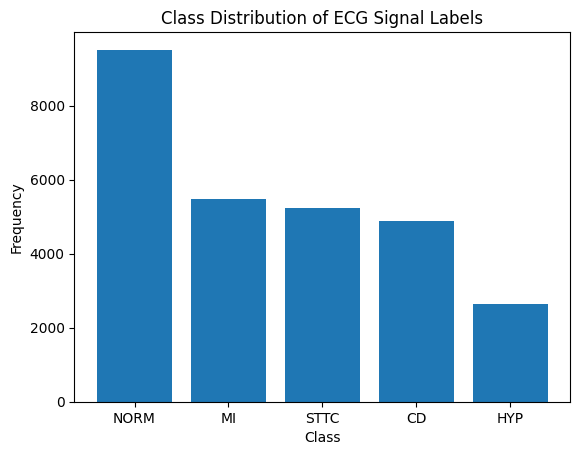

In [34]:
# Sum the rows to get the total count of each label
label_counts = labels.sum(axis=0)

# Get the labels from the column names of the DataFrame
class_labels = labels.columns

# Create a bar chart to show the class distribution
plt.bar(class_labels, label_counts)

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution of ECG Signal Labels')
plt.show()

In [9]:
from sklearn.svm import SVC


# Randomly select 5000 indices from your data
random_indices = np.random.choice(np.arange(len(filtered_signals)), size=5000, replace=False)

# Use the selected subset of data for training
X_train_subset = filtered_signals[random_indices]
y_train_subset = y_train_encoded[random_indices]

# Create and train the SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_subset, y_train_subset)


SVC()

In [32]:
from sklearn.metrics import accuracy_score

# make predictions on test set
y_pred=svm_classifier.predict(filtered_test_signals)


# compute and print accuracy score
# print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test_encoded, y_pred)))

In [35]:
accuracy = accuracy_score(y_test_encoded, y_pred)
print('Model accuracy score with default hyperparameters: {0:0.4f}'.format(accuracy))


Model accuracy score with default hyperparameters: 0.4527


1D NN

In [3]:
""" making the data ready and clear """
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()


origin_signals = origin_signals.reshape((19601, -1))
origin_test_signals = origin_test_signals.reshape((2198, -1))

y_train_flat = [label[0] for label in y_train if len(label) > 0]
y_train_encoded = label_encoder.fit_transform(y_train_flat)

y_test_flat = [label[0] for label in y_test if len(label) > 0]
y_test_encoded = label_encoder.fit_transform(y_test_flat)


missing_indices_train = [i for i, label in enumerate(y_train) if len(label) == 0]
filtered_signals = np.delete(origin_signals, missing_indices_train, axis=0)


missing_indices_test = [i for i, label in enumerate(y_test) if len(label) == 0]
filtered_test_signals = np.delete(origin_test_signals, missing_indices_test, axis=0)

# Randomly select 5000 indices from your data
random_indices = np.random.choice(np.arange(len(filtered_signals)), size=5000, replace=False)

# Use the selected subset of data for training
X_train_subset = filtered_signals[random_indices]
y_train_subset = y_train_encoded[random_indices]

In [ ]:
from sklearn import datasets
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')



model = MLPClassifier()
model.fit(X_train_subset, y_train_subset)
print(model)

expected_y  = y_test_encoded
predicted_y = model.predict(filtered_test_signals)

print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

In [4]:
""" each lead represents a separate one-dimensional sequence of data points over time """

""" a 1D CNN can learn to extract meaningful features from each lead individually
    and combine them for classification or analysis. """





In [ ]:
""" an issue with the indexes of your dataframes and arrays not matching,
 it's important to ensure that the order of data in both the dataframe and signals array is aligned """

In [9]:
# Training data
X_train = features[Y.strat_fold <= 8]
Y_train = loaded_waveletfiltered_signals[np.where(Y.strat_fold <= 8)]
Z_train = labels[Y.strat_fold <= 8]

# Cross Valuation Data
X_val = features[Y.strat_fold == 9]
Y_val = loaded_waveletfiltered_signals[np.where(Y.strat_fold == 9)]
Z_val = labels[Y.strat_fold == 9]

# Test data
X_test = features[Y.strat_fold == 10]
Y_test = loaded_waveletfiltered_signals[np.where(Y.strat_fold == 10)]
Z_test = labels[Y.strat_fold == 10]


# ensure shapes match
print(f'X_train: {X_train.shape} Y_train: {Y_train.shape} Z_train: {Z_train.shape}')
print(f'X_val: {X_val.shape} Y_val: {Y_val.shape} Z_val: {Z_val.shape}')
print(f'X_test: {X_test.shape} Y_test: {Y_test.shape} Z_test: {Z_test.shape}')

X_train: (17418, 5) Y_train: (17418, 12, 1000) Z_train: (17418, 5)
X_val: (2183, 5) Y_val: (2183, 12, 1000) Z_val: (2183, 5)
X_test: (2198, 5) Y_test: (2198, 12, 1000) Z_test: (2198, 5)


In [10]:
X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [11]:
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_val_scaled = Y_scaler.transform(Y_val.reshape(-1, Y_val.shape[-1])).reshape(Y_val.shape)
Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

In [12]:
del loaded_waveletfiltered_signals

Model

In [13]:
# X model
X_input = tf.keras.layers.Input(X_train_scaled.shape[1:], name="X_input")
X = Dense(128, activation='relu', name="X_dense_1")(X_input)
X = Dropout(0.4, name="X_dropout_1")(X)
X = Dense(128, activation='relu', name="X_dense_2")(X)
X = Dropout(0.4, name="X_dropout_2")(X)
X = Dense(64, activation='relu', name="X_dense_3")(X)
X = Dropout(0.4, name="X_dropout_3")(X)
X = Dense(32, activation='relu', name="X_dense_4")(X)
outputX = Dense(Z_train.shape[-1], activation='sigmoid', name="X_dense_5")(X)

modelX = tf.keras.Model(inputs=X_input, outputs=outputX)

2023-07-23 17:07:44.811271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-23 17:07:44.811937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-23 17:07:44.812502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')


In [21]:
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

Virtual devices cannot be modified after being initialized


In [15]:
# gpus = tf.config.experimental.list_physical_devices('GPU')

    
modelX.compile(
    loss = 'binary_crossentropy',
    optimizer = keras.optimizers.legacy.Adam(),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

modelX.fit(
    X_train_scaled, Z_train, epochs = 40, batch_size=32, validation_data=(X_val_scaled, Z_val)
)

Epoch 1/40
545/545 [==============================] - 13s 8ms/step - loss: 0.4989 - binary_accuracy: 0.7802 - precision: 0.6785 - recall: 0.2606 - val_loss: 0.4762 - val_binary_accuracy: 0.7898 - val_precision: 0.7265 - val_recall: 0.2832
Epoch 2/40
545/545 [==============================] - 4s 8ms/step - loss: 0.4748 - binary_accuracy: 0.7904 - precision: 0.7095 - recall: 0.3001 - val_loss: 0.4722 - val_binary_accuracy: 0.7927 - val_precision: 0.7245 - val_recall: 0.3029
Epoch 3/40
545/545 [==============================] - 5s 9ms/step - loss: 0.4689 - binary_accuracy: 0.7936 - precision: 0.7144 - recall: 0.3160 - val_loss: 0.4702 - val_binary_accuracy: 0.7935 - val_precision: 0.7235 - val_recall: 0.3090
Epoch 4/40
545/545 [==============================] - 6s 11ms/step - loss: 0.4662 - binary_accuracy: 0.7963 - precision: 0.7230 - recall: 0.3246 - val_loss: 0.4668 - val_binary_accuracy: 0.7937 - val_precision: 0.7286 - val_recall: 0.3055
Epoch 5/40
545/545 [==========================

In [16]:
# Y model

Y_input = tf.keras.layers.Input(Y_train_scaled.shape[1:], name="Y_input")

Y = Conv1D(32, 3, padding='same', name="Y_conv_1")(Y_input)
Y = BatchNormalization(name="Y_norm_1")(Y)
Y = ReLU(name="Y_relu_1")(Y)
Y = MaxPooling1D(2, name="Y_max_1")(Y)

Y = Conv1D(64, 3, padding='same', name="Y_conv_2")(Y)
Y = BatchNormalization(name="Y_norm_2")(Y)
Y = ReLU(name="Y_relu_2")(Y)
Y = MaxPooling1D(2, name="Y_max_2")(Y)

Y = Conv1D(128, 3, padding='same', name="Y_conv_3")(Y)
Y = BatchNormalization(name="Y_norm_3")(Y)
Y = ReLU(name="Y_relu_3")(Y)

Y = GlobalAveragePooling1D(name="Y_global")(Y)

outputY = Dropout(0.4, name="Y_dropout")(Y)

In [48]:
outputY.shape

TensorShape([None, 128])

In [17]:
Z = Concatenate(name="Z_concat")([outputX, outputY])
Z = Dense(64, activation='relu', name="Z_dense_1")(Z)
Z = Dropout(0.4, name="Z_dropout_1")(Z)
Z = Dense(64, activation='relu', name="Z_dense_2")(Z)
Z = Dropout(0.4, name="Z_dropout_2")(Z)
output = Dense(Z_train.shape[-1], activation="sigmoid", name="Z_dense_3")(Z)

modelZ = tf.keras.Model(inputs=[X_input, Y_input], outputs=output)

In [20]:
modelZ.compile(
    loss='binary_crossentropy',
    optimizer= keras.optimizers.legacy.Adam(),
    metrics=['binary_accuracy', 'Precision', 'Recall']
)


modelZ.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Y_input (InputLayer)        [(None, 12, 1000)]           0         []                            
                                                                                                  
 Y_conv_1 (Conv1D)           (None, 12, 32)               96032     ['Y_input[0][0]']             
                                                                                                  
 Y_norm_1 (BatchNormalizati  (None, 12, 32)               128       ['Y_conv_1[0][0]']            
 on)                                                                                              
                                                                                                  
 Y_relu_1 (ReLU)             (None, 12, 32)               0         ['Y_norm_1[0][0]']      

                                                                                                  
 Y_dropout (Dropout)         (None, 128)                  0         ['Y_global[0][0]']            
                                                                                                  
 Z_concat (Concatenate)      (None, 133)                  0         ['X_dense_5[0][0]',           
                                                                     'Y_dropout[0][0]']           
                                                                                                  
 Z_dense_1 (Dense)           (None, 64)                   8576      ['Z_concat[0][0]']            
                                                                                                  
 Z_dropout_1 (Dropout)       (None, 64)                   0         ['Z_dense_1[0][0]']           
                                                                                                  
 Z_dense_2

In [32]:
from keras.utils import plot_model

tf.keras.utils.plot_model(modelZ, show_shapes=True)
plot_model(modelZ, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:

fitting = modelZ.fit(
    [X_train_scaled, Y_train_scaled], Z_train, epochs=50, batch_size=32, validation_data=([X_val_scaled, Y_val_scaled], Z_val)
)

2023-07-23 20:19:49.599459: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 836064000 exceeds 10% of free system memory.
2023-07-23 20:19:57.815748: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 836064000 exceeds 10% of free system memory.


Epoch 1/50
545/545 [==============================] - 12s 17ms/step - loss: nan - binary_accuracy: 0.7516 - precision: 0.5356 - recall: 0.1877 - val_loss: nan - val_binary_accuracy: 0.7448 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
545/545 [==============================] - 9s 16ms/step - loss: nan - binary_accuracy: 0.7452 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_binary_accuracy: 0.7448 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
545/545 [==============================] - 10s 18ms/step - loss: nan - binary_accuracy: 0.7452 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_binary_accuracy: 0.7448 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
545/545 [==============================] - 10s 18ms/step - loss: nan - binary_accuracy: 0.7452 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: nan - val_binary_accuracy: 0.7448 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5

In [38]:
modelX.evaluate(X_test_scaled, Z_test)

69/69 [==============================] - 0s 6ms/step - loss: nan - binary_accuracy: 0.7460 - precision: 0.0000e+00 - recall: 0.0000e+00


[nan, 0.7459507584571838, 0.0, 0.0]

In [39]:
features

,sex,age,infarction_stadium1,infarction_stadium2,heart_axis
ecg_id,,,,,
1,1,56.0,0.0,0.0,0.0
2,0,19.0,0.0,0.0,0.0
3,1,37.0,0.0,0.0,0.0
4,0,24.0,0.0,0.0,0.0
5,1,19.0,0.0,0.0,0.0
...,...,...,...,...,...
21833,1,67.0,0.0,0.0,1.0
21834,0,30.0,4.0,0.0,5.0
21835,1,59.0,0.0,0.0,5.0
